In [363]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
from numpy import longdouble
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('spm_model_2.5k_justPeriods_lowercase.model')

text = "this is a sample sentence to tokenize."
tokens = sp.encode_as_pieces(text)
print(tokens)
print(sp.encode_as_ids(text))


['▁this', '▁is', '▁a', '▁sa', 'mp', 'le', '▁sent', 'ence', '▁to', '▁to', 'ke', 'n', 'ize', '.']
[14, 23, 12, 283, 896, 114, 378, 514, 5, 5, 352, 43, 1234, 3]


In [364]:
from numpy import uint8


def one_hot(vocab_size, sequence):
    v_sequence = []
    for token in sequence:
        vectorized = np.zeros(vocab_size, dtype=uint8)
        vectorized[token] = 1
        v_sequence.append(vectorized)
    return v_sequence


In [365]:
import string
import re

def stripMost(text):
    # Replace all non-alphanumeric characters except periods and spaces with an empty string
    return re.sub(r'[^a-zA-Z0-9. ]+', '', text)

def load_emails(batch_size, windows_size):

    max_sequence_length = 800
    dataset = []
    batch_counter = 0
    batch = []
    
    prefix = './PhishingEmails/' #change this to the prefile thing such as './celebA'

    for file in tqdm(os.listdir(prefix)):
        
        with open(prefix + file) as jsonFile:
            jsonStr = jsonFile.read() #json file as a string
            email_dict = json.loads(jsonStr) #converts to dictionary
        
        setupData = sp.encode_as_ids(stripMost(email_dict['email_subject'].strip().lower()).strip() + " " + stripMost(email_dict['email_body'].strip()).lower().strip())
        if(len(setupData) <= max_sequence_length):

            for i in range(0, len(setupData) - windows_size - 1, windows_size):

                if batch_counter >= batch_size:
                    dataset.append(batch)
                    batch = []
                    batch_counter = 0
                
                hot = np.array(one_hot(2500,setupData[i:i+windows_size]))
                batch.append(hot)
                # print(hot.shape)

                batch_counter += 1
                
                
                    
    dataset = np.array(dataset)
    np.random.shuffle(dataset)

    
    return dataset

In [366]:
#Initialize helpful functions for math
def sigmoid(x: np.ndarray):
    return 1/(1+np.exp(-1*x))

def sigmoid_derivative(x: np.ndarray):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x: np.ndarray):
    return np.tanh(x)
    
def tanh_derivative(x:np.ndarray):
    return 1-np.square(tanh(x))

def softmax(x: np.ndarray):
    return np.exp(x)/np.sum(np.exp(x))

def cross_entropy(yhat, y, epsilon=1e-12):
    predictions = np.clip(yhat, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(y*np.log(predictions+1e-9))/N
    return ce

def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (input_size, output_size)).astype(longdouble) * np.sqrt(1 / (input_size + output_size))



In [367]:
#initializes the weights of the network
def initialize_cell(input_size, hidden_size):
    
    cell = {}

    cell["W_i"] = initWeights(input_size+hidden_size, hidden_size)#input gate weights
    cell["W_f"] = initWeights(input_size+hidden_size, hidden_size)#forget gate weights
    cell["W_c"] = initWeights(input_size+hidden_size, hidden_size) #candidate gate weights
    cell["W_o"] = initWeights(input_size+hidden_size, hidden_size) #output gate weights
    cell["W_y"] = initWeights(hidden_size, 2500)#final gate weights

    #not sure if the biases need to be 3d...
    cell["b_i"] = np.zeros(hidden_size,dtype=longdouble) #input gate biases
    cell["b_f"] = np.zeros(hidden_size,dtype=longdouble) #forget gate biases
    cell["b_c"] = np.zeros(hidden_size,dtype=longdouble) #candidate gate biases
    cell["b_o"] = np.zeros(hidden_size,dtype=longdouble) #output gate biases
    cell["b_y"] = np.zeros(2500,dtype=longdouble) #final gate biases

    return cell

In [368]:
#forward pass of all gates
def forward_pass(cell, prevA, prevC, X):

    input = np.hstack((X, prevA), dtype=longdouble)

    forward = {}

    forward["F"] = sigmoid(input.dot(cell["W_f"]) + cell["b_f"])

    forward["_c"] = input.dot(cell["W_c"]) + cell["b_c"]
    
    forward["C"] = tanh(forward["_c"])

    forward["I"] = sigmoid(input.dot(cell["W_i"]) + cell["b_i"])

    forward["O"] = sigmoid(input.dot(cell["W_o"]) + cell["b_o"])


    forward["prevA"] = prevA
    forward["prevC"] = prevC
    forward["C_t"] = (forward["prevC"] * forward["F"]) + (forward["I"] * forward["C"])
    forward["A_t"] = forward["O"] * tanh(forward["C_t"])

    forward["Z_t"] = forward["A_t"].dot(cell["W_y"]) + cell["b_y"]

    forward["Yhat"] = softmax(forward["Z_t"][0])


    for i in range(1,len(forward["Z_t"])):
        sm = softmax(forward["Z_t"][i])
        forward["Yhat"] = np.vstack((forward["Yhat"], sm))

    return forward

In [369]:
def gradient(forward, cell, X, Y, lprimea, lprimec, input_size):
    Y = np.array(Y)
    
    grads = {}

    input = np.hstack((X, forward["prevA"]),dtype=longdouble)
    

    dldA_t = (forward["Yhat"]- Y).dot(np.transpose(cell["W_y"])) + lprimea
    
    dldC_t = lprimec + (forward["O"] * tanh_derivative(forward["C_t"])) * dldA_t 

    TdLdw_f = (dldC_t * forward["prevC"] * forward["F"]*(1-forward["F"])) 

    TdLdw_c = (dldC_t * forward["I"]*tanh_derivative(forward["_c"]))
    TdLdw_o = (dldA_t * tanh(forward["C_t"]) * forward["O"] * (1-forward["O"]))
    TdLdw_i = (dldC_t * forward["C"] * forward["I"] * (1-forward["I"]))
    TdLdw_y = (forward["Yhat"]-Y)

    woa = cell["W_o"][input_size:, :]
    wca = cell["W_c"][input_size:, :]
    wia = cell["W_i"][input_size:, :]
    wfa = cell["W_f"][input_size:, :]

    grads["dLda_prev"] = TdLdw_o.dot(woa.T) + TdLdw_c.dot(wca.T) + TdLdw_i.dot(wia.T) + TdLdw_f.dot(wfa.T)
    grads["dLdc_prev"] = (lprimec + (forward["O"] * tanh_derivative(forward["C_t"]) * dldA_t)) * forward["F"]

    grads["dLdw_f"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_f))
    grads["dLdw_c"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_c))
    grads["dLdw_o"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_o))
    grads["dLdw_i"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_i))
    grads["dLdw_y"] = np.atleast_2d(np.atleast_2d(forward["A_t"])).T.dot(np.atleast_2d(TdLdw_y))

    grads["dLdb_f"] = TdLdw_f.sum(axis=0)
    grads["dLdb_c"] = TdLdw_c.sum(axis=0)
    grads["dLdb_o"] = TdLdw_o.sum(axis=0)
    grads["dLdb_i"] = TdLdw_i.sum(axis=0)
    grads["dLdb_y"] = TdLdw_y.sum(axis=0)
    

    loss = cross_entropy(forward["Yhat"], Y)

    return grads, loss


In [370]:
def clip(derivative, norm):
    dernorm = np.linalg.norm(derivative)
    if(dernorm > norm):
        
        derivative = norm/dernorm * derivative

    return derivative

In [371]:
import copy

def descent(cell, X, input_size, hidden_size, batch_size, lr, sequence_len, prev_change, momentum):

    gradientTot = {}
    lossTot = 0

    labels = []

    inputs = []

    allForwards = []

    lprimea = np.zeros((batch_size, hidden_size))
    lprimec = np.zeros((batch_size, hidden_size))

    prevA =  np.zeros((batch_size,hidden_size))
    prevC = np.zeros((batch_size,hidden_size))

    gradientTot["dLdw_f"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_c"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_o"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_i"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_y"] = np.zeros((hidden_size, 2500),dtype=longdouble)
    gradientTot["dLdb_f"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_c"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_o"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_i"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_y"] = np.zeros(2500,dtype=longdouble)

    
    inp = np.reshape(X[:, 1:2, :],(batch_size,2500))
    for i in range(1, sequence_len-1):

        label = np.reshape(X[:, i+1:i+2, :],(batch_size,2500))
        forward = forward_pass(cell, prevA, prevC, inp)

        inputs.append(inp)
        labels.append(label)
        
        inp = label

        prevA = forward["A_t"]
        prevC = forward["C_t"]
        
        allForwards.append(forward)

    for i in range(len(allForwards)-1, -1, -1):
     
        grad, loss = gradient(allForwards[i], cell, inputs[i], labels[i], lprimea, lprimec, input_size)
        lprimea = grad["dLda_prev"]
        lprimec = grad["dLdc_prev"]

        gradientTot["dLdw_f"] += grad["dLdw_f"]
        gradientTot["dLdw_c"] += grad["dLdw_c"]
        gradientTot["dLdw_o"] += grad["dLdw_o"]
        gradientTot["dLdw_i"] += grad["dLdw_i"]
        gradientTot["dLdw_y"] += grad["dLdw_y"]
        
        gradientTot["dLdb_f"] += grad["dLdb_f"]
        gradientTot["dLdb_c"] += grad["dLdb_c"]
        gradientTot["dLdb_o"] += grad["dLdb_o"]
        gradientTot["dLdb_i"] += grad["dLdb_i"]
        gradientTot["dLdb_y"] += grad["dLdb_y"]

        lossTot += loss

    gradientTot["dLdw_f"] = clip(gradientTot["dLdw_f"]/batch_size,1) * lr + momentum * prev_change["dLdw_f"]
    gradientTot["dLdw_c"] = clip(gradientTot["dLdw_c"]/batch_size,1) * lr + momentum * prev_change["dLdw_c"]
    gradientTot["dLdw_o"] = clip(gradientTot["dLdw_o"]/batch_size,1) * lr + momentum * prev_change["dLdw_o"]
    gradientTot["dLdw_i"] = clip(gradientTot["dLdw_i"]/batch_size,1) * lr + momentum * prev_change["dLdw_i"]
    gradientTot["dLdw_y"] = clip(gradientTot["dLdw_y"]/batch_size,1) * lr + momentum * prev_change["dLdw_y"]



    cell["W_f"] = cell["W_f"] - gradientTot["dLdw_f"] * lr
    cell["W_c"] = cell["W_c"] - gradientTot["dLdw_c"] * lr
    cell["W_o"] = cell["W_o"] - gradientTot["dLdw_o"] * lr
    cell["W_i"] = cell["W_i"] - gradientTot["dLdw_i"] * lr
    cell["W_y"] = cell["W_y"] - gradientTot["dLdw_y"] * lr

    cell["b_f"] = cell["b_f"] - gradientTot["dLdb_f"]/batch_size * lr
    cell["b_c"] = cell["b_c"] - gradientTot["dLdb_c"]/batch_size * lr
    cell["b_o"] = cell["b_o"] - gradientTot["dLdb_o"]/batch_size * lr
    cell["b_i"] = cell["b_i"] - gradientTot["dLdb_i"]/batch_size * lr
    cell["b_y"] = cell["b_y"] - gradientTot["dLdb_y"]/batch_size * lr

    return gradientTot, lossTot

In [372]:
def get_acc(cell, dataset, batch_size, hs, seq_len):
     
     totacc = 0
     
     for data in dataset:

        prevA =  np.zeros((batch_size,hs))
        prevC = np.zeros((batch_size,hs))

        acc=0


        inp = np.reshape(data[:, 1:2, :],(batch_size,2500))
        for i in range(1, seq_len-1):

            label = np.reshape(data[:, i+1:i+2, :],(batch_size,2500))
   
            forward = forward_pass(cell, prevA, prevC, inp)
           
            for j in range(0,batch_size):
            
                acc += forward["Yhat"][j][np.where(label[j] == 1)]
            
            inp = label

            prevA = forward["A_t"]
            prevC = forward["C_t"]
  
        totacc += acc/batch_size/(seq_len-1)

        
     return totacc


In [376]:
def train(dataset, input_size, hidden_size, batch_size, lr, sequence_len, epochs):

    cell = initialize_cell(input_size, hidden_size)

    prev_change = {} #just the previous change for meomentum
    prev_change["dLdw_f"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_c"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_o"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_i"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_y"] = np.zeros((hidden_size, 2500),dtype=longdouble)
    prev_change["dLdb_f"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_c"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_o"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_i"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_y"] = np.zeros(2500,dtype=longdouble)

    testset = dataset[100:105]

    losses = []
    acc = []
    print(len(dataset))
    for e in range(0,epochs):
        for i in tqdm(range(0,500)):
            prev_change, loss = descent(cell, dataset[i], input_size, hidden_size, batch_size, lr, sequence_len, prev_change, 0.99)
            if i % 25 == 0:
                acc.append(get_acc(cell, testset, batch_size,hidden_size, sequence_len))
            if i != 0 and i % 50 == 0:
                plt.plot(np.arange(len(losses)) * batch_size, losses)
                plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("loss")
                plt.show()

                plt.plot(np.arange(len(acc))*batch_size, acc)
                plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("loss")
                plt.show()
            losses.append(loss)



    plt.plot(np.arange(len(losses)) * batch_size, losses)
    plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()

    plt.plot(np.arange(len(acc))*batch_size, acc)
    plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()
    return cell

In [377]:

def grid_search():

        for BS in [16,8,4]:

            for SL in [10,25,50]:

                dataset = load_emails(BS, SL)

                for HS in [192,128]:
                    for LR in [0.1,0.01,0.001,0.0001]:
                        
                        train(dataset,2500, HS, BS, LR, SL)
                    



In [378]:


sequence_len = 25

bsize = 32
input_size = 2500

hidden_size = 128




dataset = load_emails(bsize, sequence_len)

100%|██████████| 3332/3332 [00:05<00:00, 592.88it/s]


1826


 10%|█         | 50/500 [03:12<24:30,  3.27s/it] 

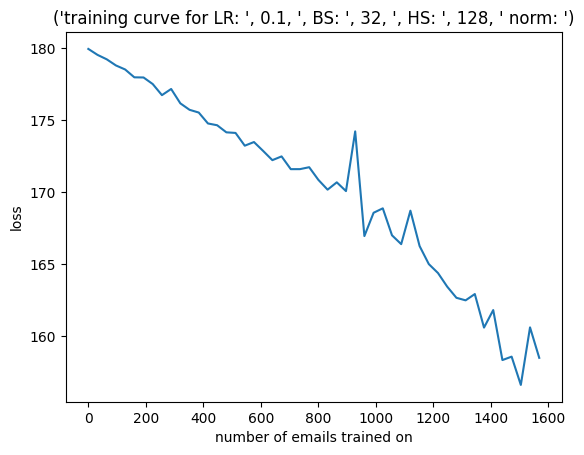

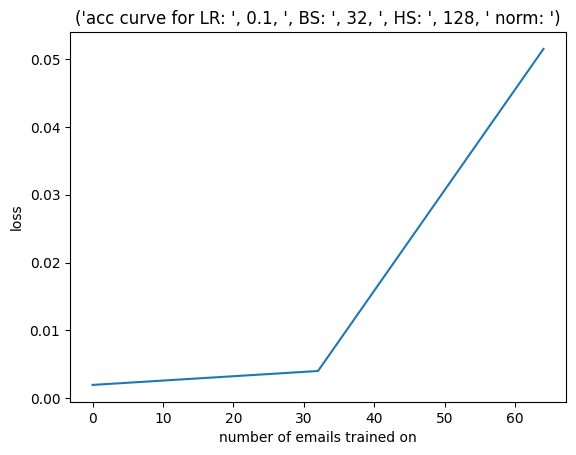

 20%|██        | 100/500 [06:23<22:17,  3.34s/it]

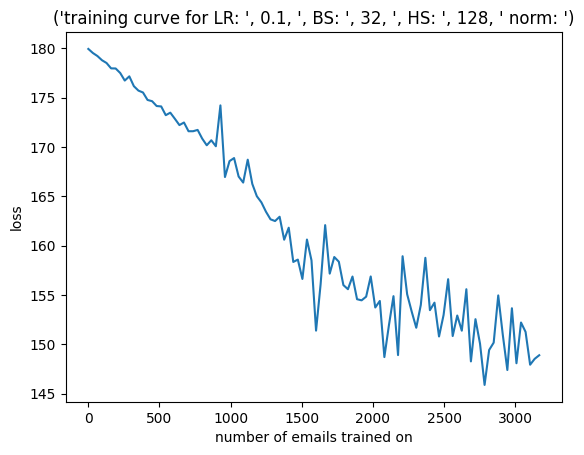

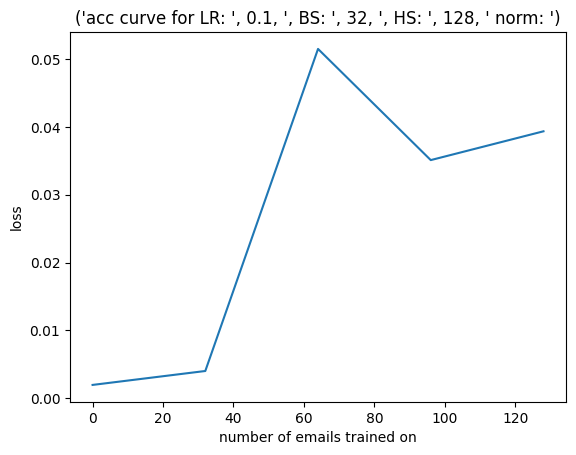

 30%|███       | 150/500 [09:43<20:40,  3.55s/it]

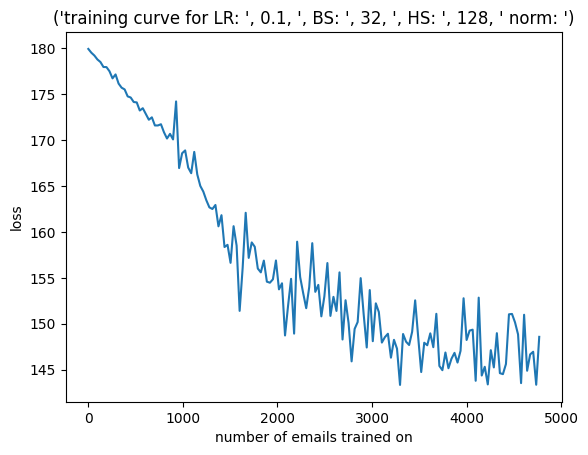

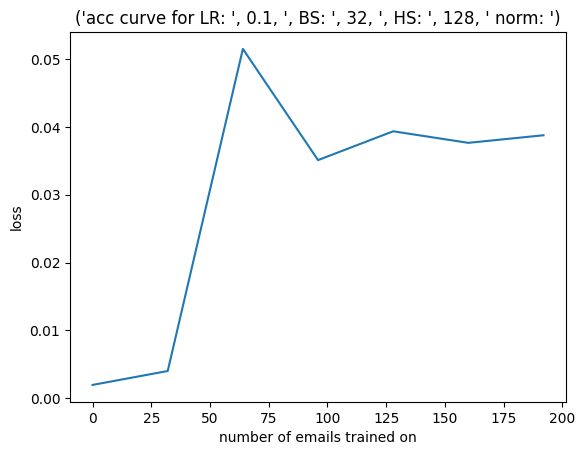

 40%|████      | 200/500 [13:02<17:46,  3.55s/it]

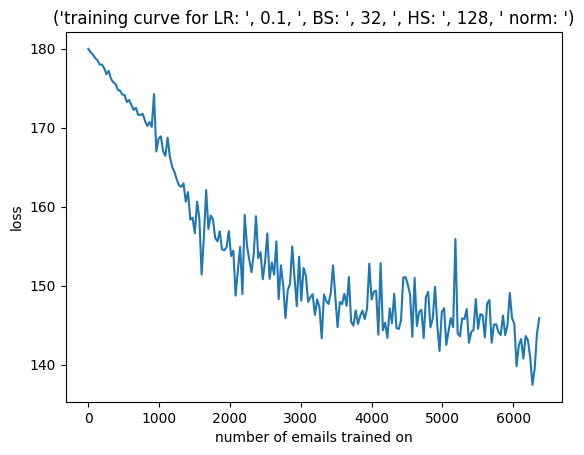

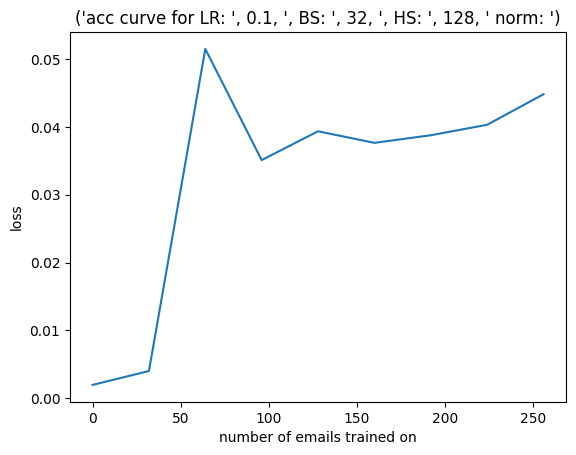

 50%|█████     | 250/500 [16:16<14:00,  3.36s/it]

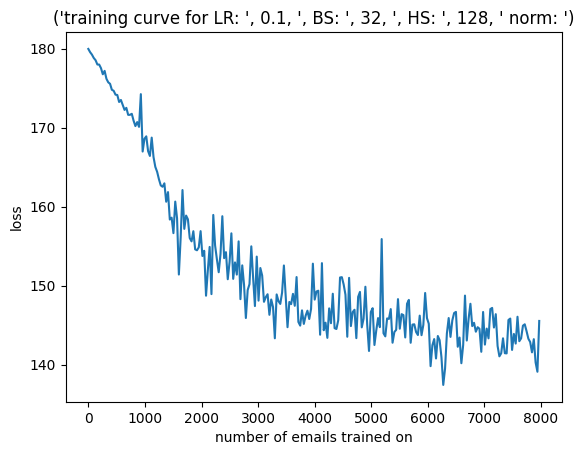

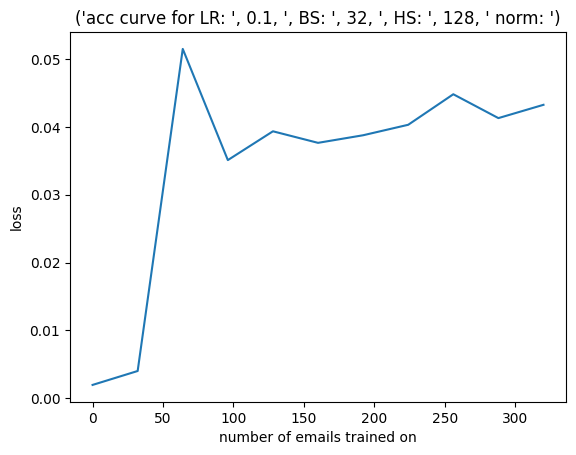

 60%|██████    | 300/500 [19:28<11:11,  3.36s/it]

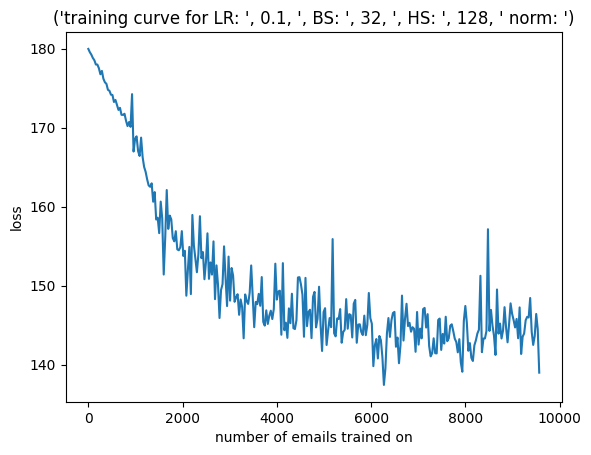

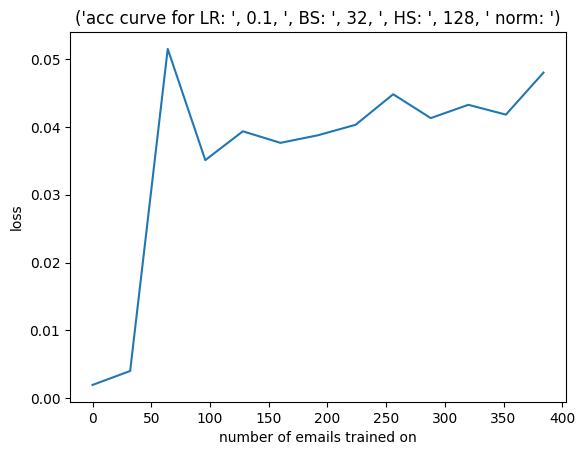

 70%|███████   | 350/500 [22:36<08:14,  3.30s/it]

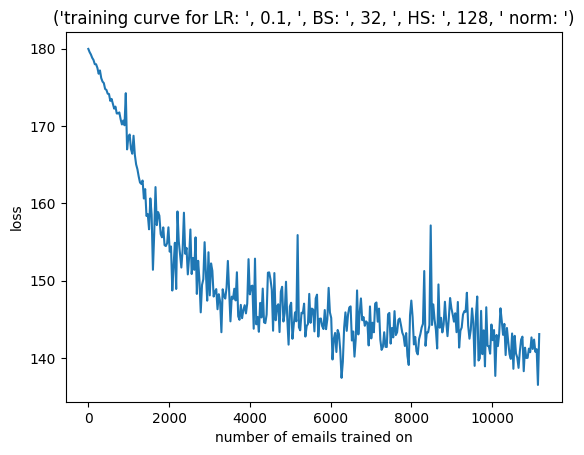

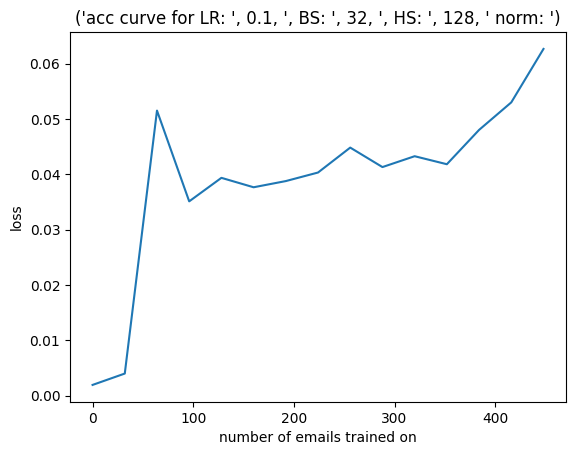

 80%|████████  | 400/500 [25:55<06:19,  3.79s/it]

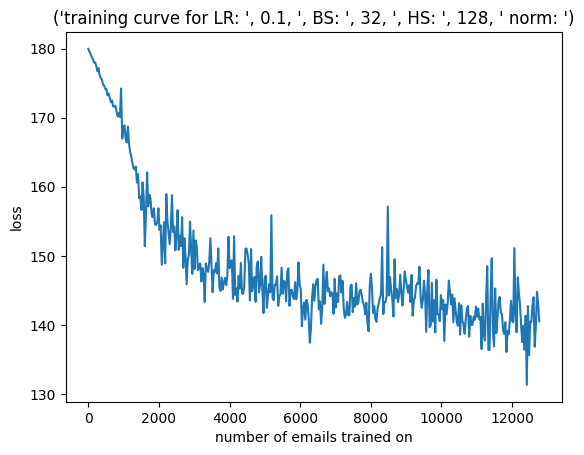

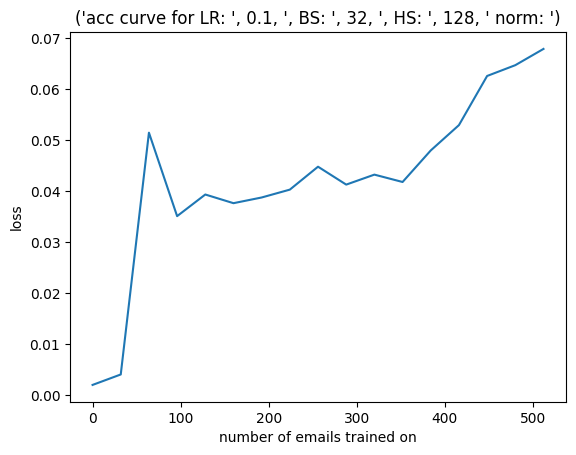

 90%|█████████ | 450/500 [29:22<03:04,  3.68s/it]

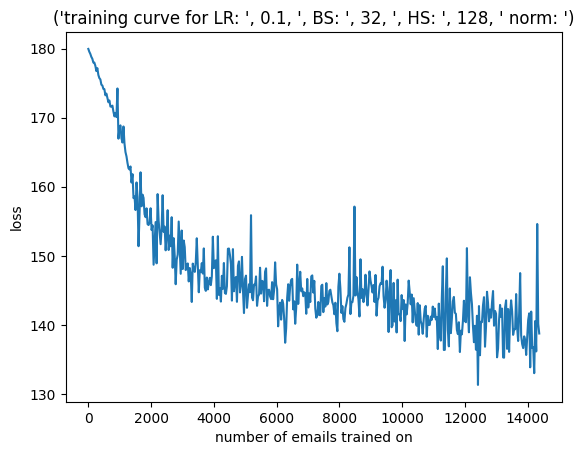

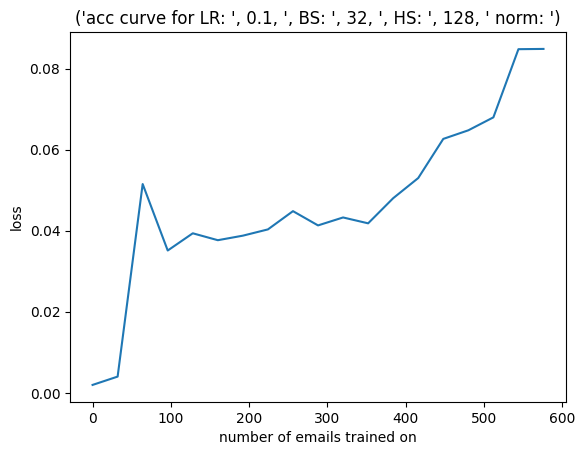

100%|██████████| 500/500 [32:48<00:00,  3.94s/it]


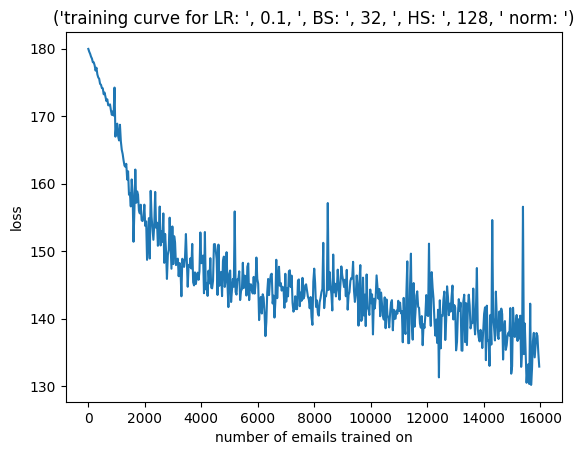

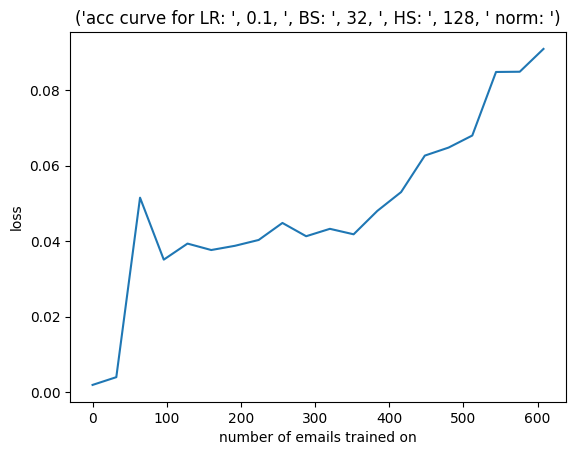

In [379]:
#initial overflow
#adam??
#its weird that the jumps get larger in the way that they do. seems to imply something is being carried over but im not sure
cell = train(dataset,input_size, 128, 32, 0.1, sequence_len,1)

In [423]:
def more_train(c, dataset, input_size, hidden_size, batch_size, lr, sequence_len, epochs):

    #GET RANDOM NUMBER SELECTOR FOR THE SHITTTTTTTTT
    testset = dataset[560:565]

    prev_change = {} #just the previous change for meomentum
    prev_change["dLdw_f"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_c"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_o"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_i"] = np.zeros((input_size+hidden_size, hidden_size))
    prev_change["dLdw_y"] = np.zeros((hidden_size, 2500),dtype=longdouble)
    prev_change["dLdb_f"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_c"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_o"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_i"] = np.zeros(hidden_size,dtype=longdouble)
    prev_change["dLdb_y"] = np.zeros(2500,dtype=longdouble)

    losses = []
    acc = []
    for e in range(0,epochs):
        for i in tqdm(range(700,1700)):
            prev_change, loss = descent(c, dataset[i], input_size, hidden_size, batch_size, lr, sequence_len, prev_change, 0.99)
            if i % 25 == 0:
                acc.append(get_acc(c, testset, batch_size,hidden_size, sequence_len))
            if i != 0 and i % 50 == 0:
                plt.plot(np.arange(len(losses)) * batch_size, losses)
                plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("loss")
                plt.show()

                plt.plot(np.arange(len(acc))*batch_size, acc)
                plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("accuracy")
                plt.show()
            losses.append(loss)



    plt.plot(np.arange(len(losses)) * batch_size, losses)
    plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()

    plt.plot(np.arange(len(acc))*batch_size, acc)
    plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()
    return c

  0%|          | 0/1000 [00:00<?, ?it/s]

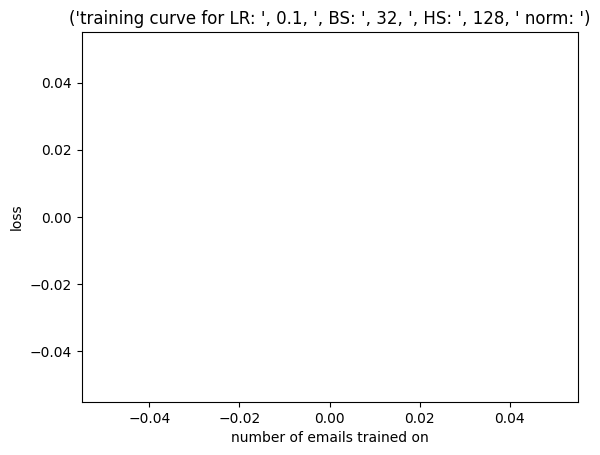

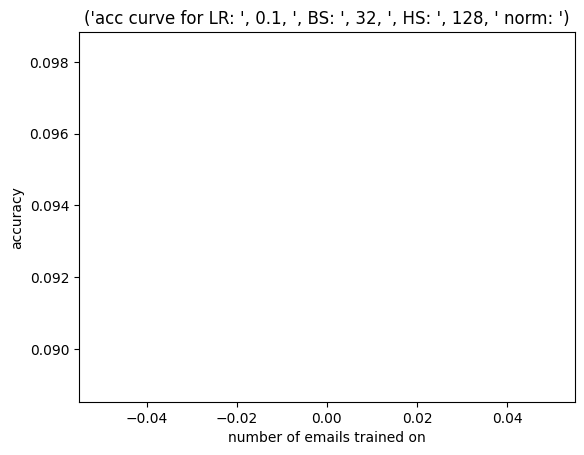

  5%|▌         | 50/1000 [03:18<53:06,  3.35s/it]  

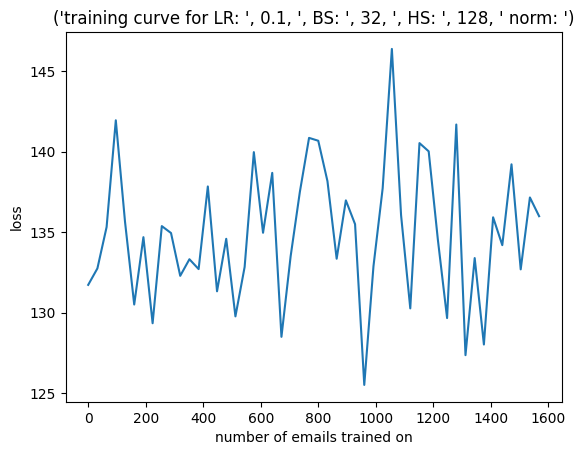

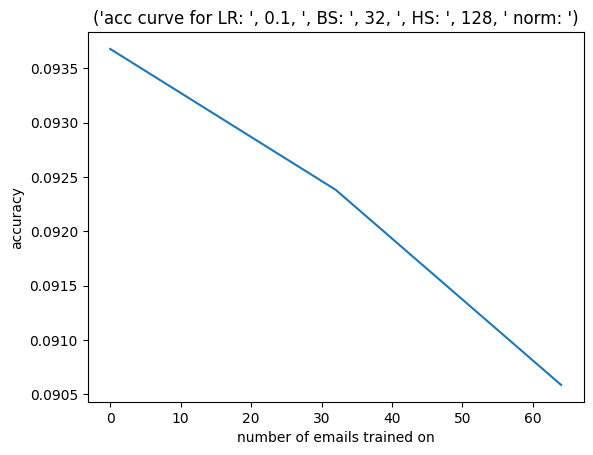

 10%|█         | 100/1000 [06:37<51:51,  3.46s/it] 

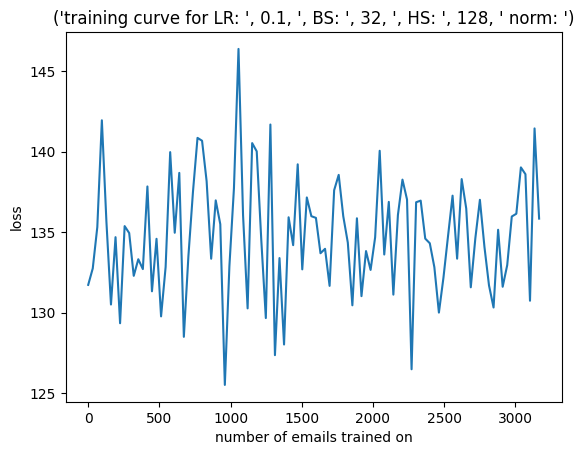

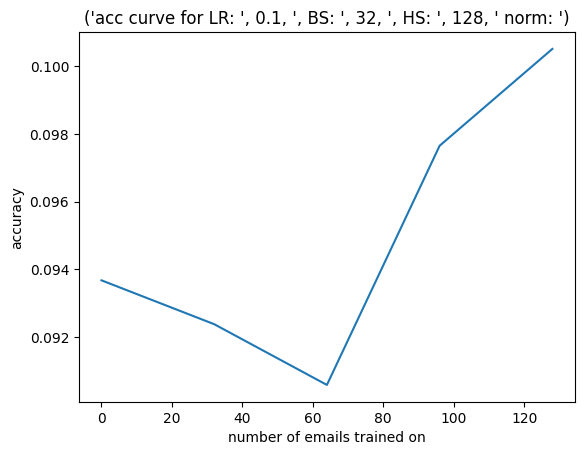

 15%|█▌        | 150/1000 [10:11<54:51,  3.87s/it]  

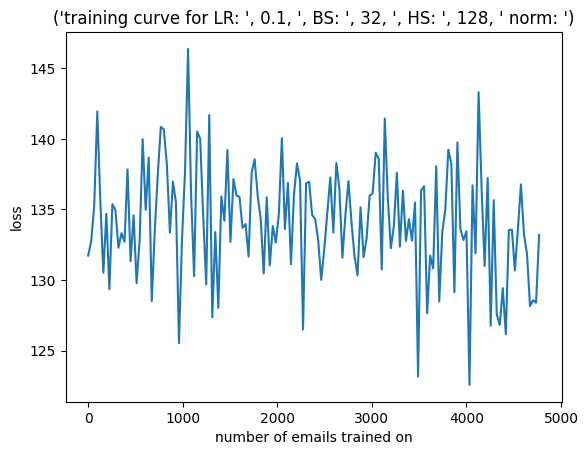

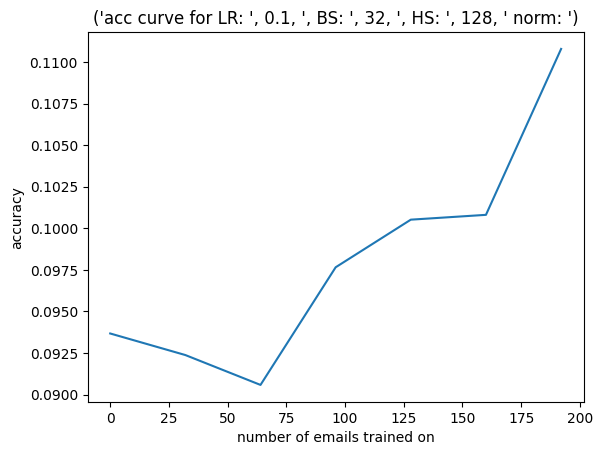

 20%|██        | 200/1000 [13:37<48:30,  3.64s/it]  

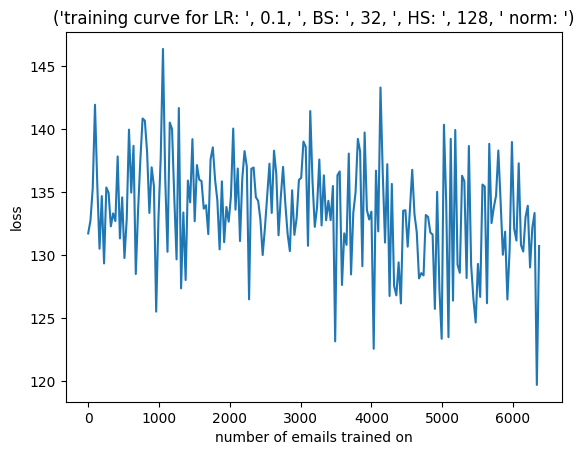

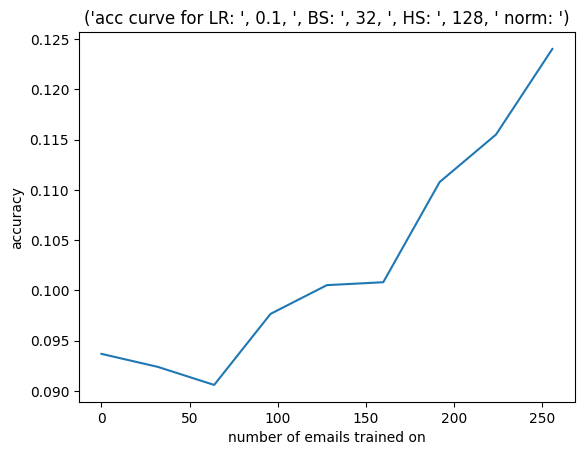

 25%|██▌       | 250/1000 [17:00<46:21,  3.71s/it]  

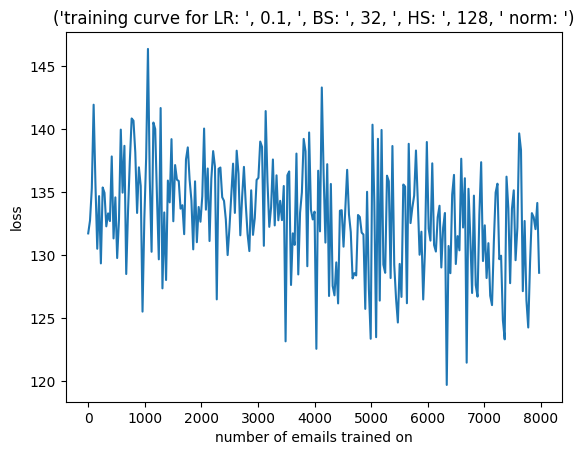

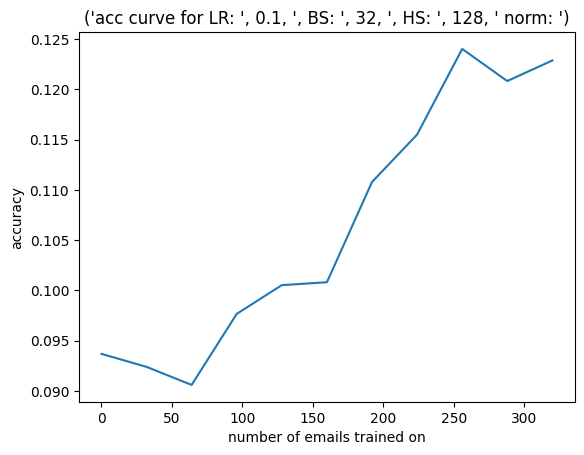

 30%|███       | 300/1000 [20:36<40:50,  3.50s/it]  

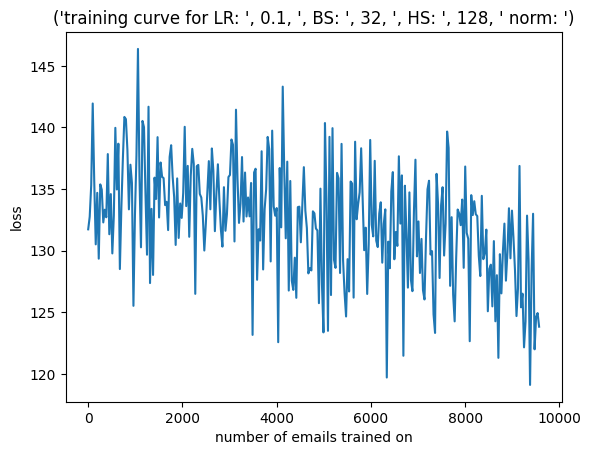

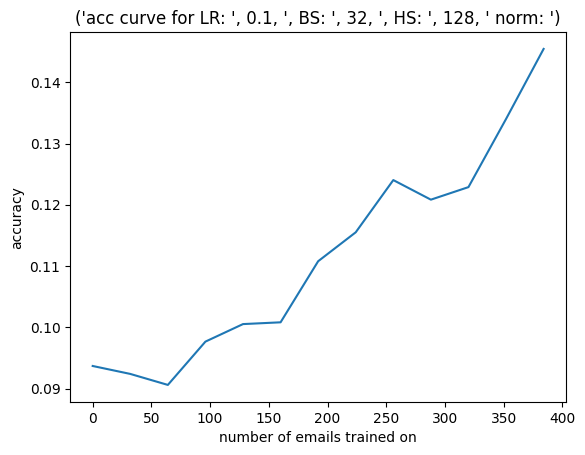

 35%|███▌      | 350/1000 [23:49<36:58,  3.41s/it]  

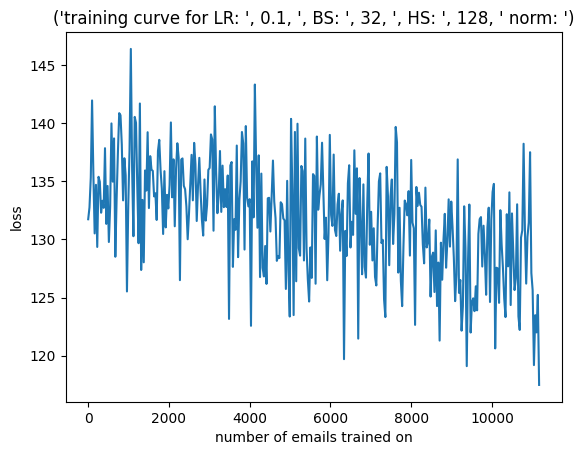

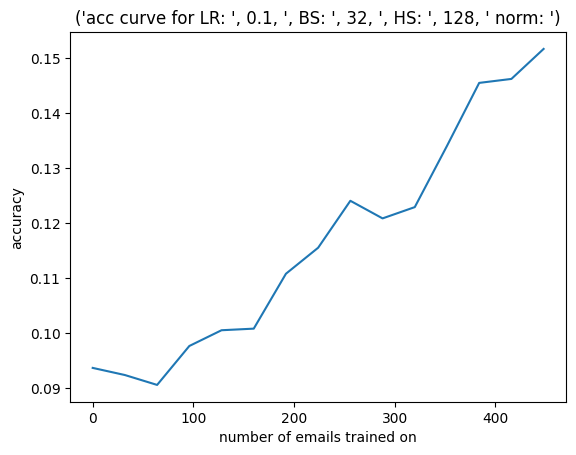

 40%|████      | 400/1000 [26:56<32:49,  3.28s/it]  

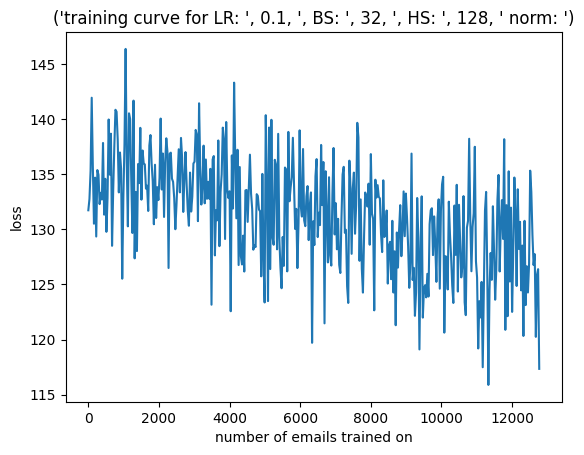

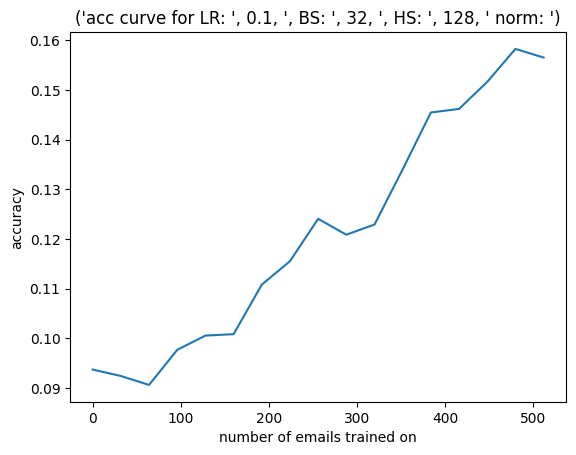

 45%|████▌     | 450/1000 [30:05<29:44,  3.25s/it]  

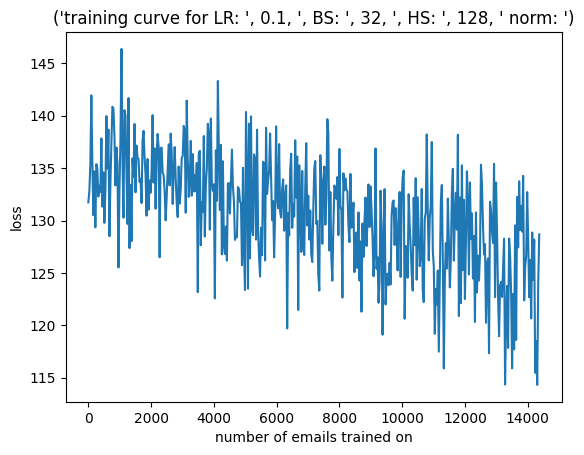

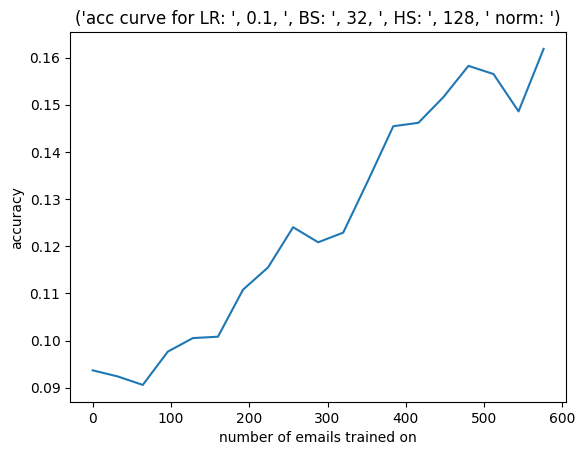

 50%|█████     | 500/1000 [33:15<27:04,  3.25s/it]

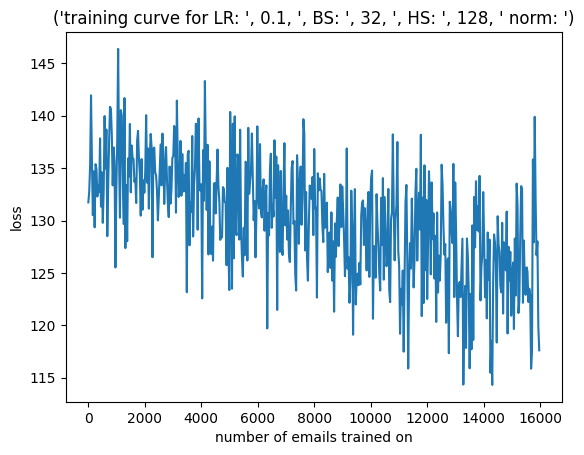

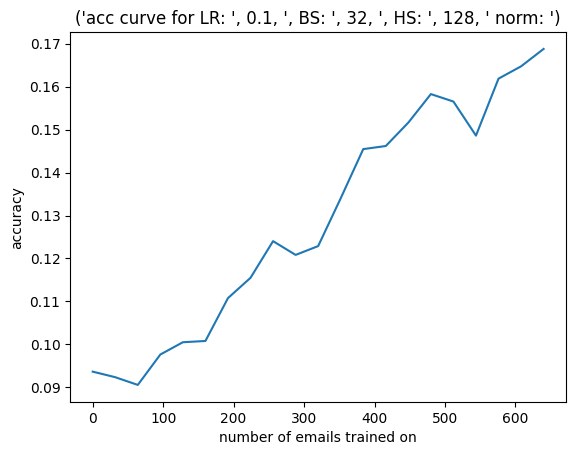

 55%|█████▌    | 550/1000 [36:22<24:38,  3.28s/it]

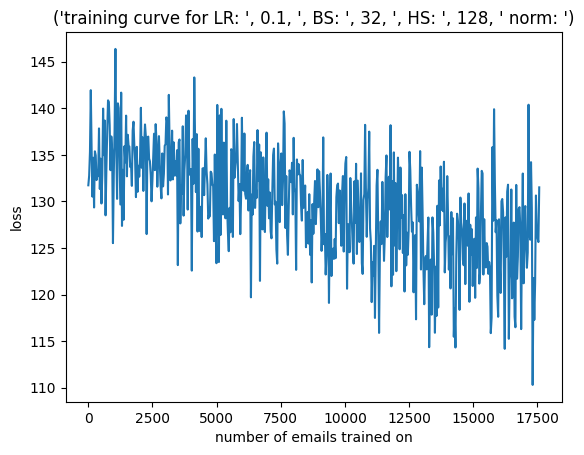

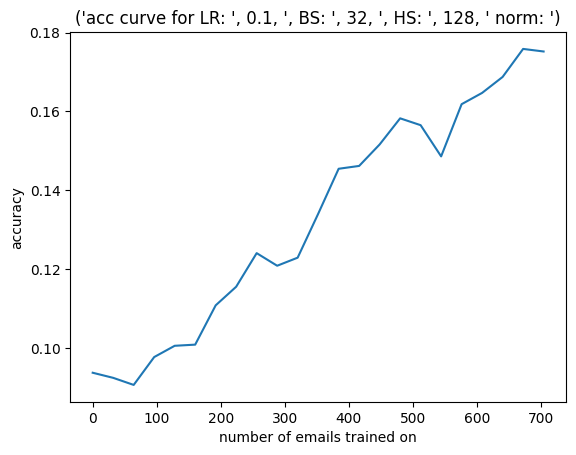

 60%|██████    | 600/1000 [39:29<22:05,  3.31s/it]

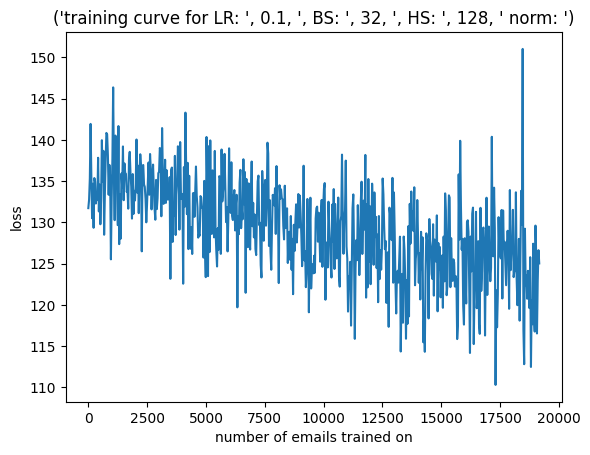

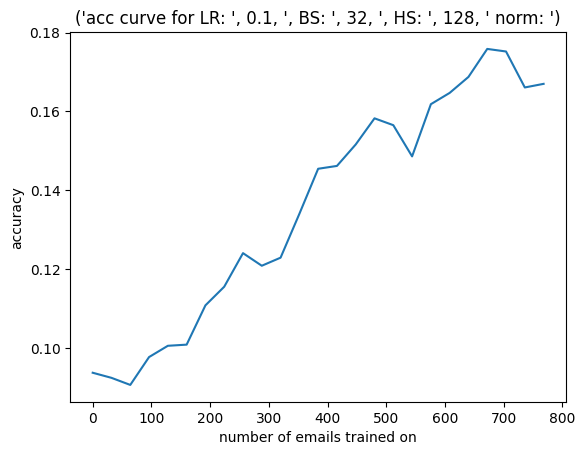

 65%|██████▌   | 650/1000 [42:39<19:25,  3.33s/it]

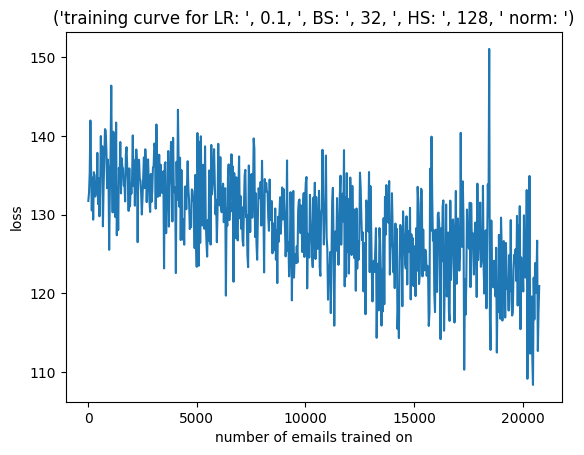

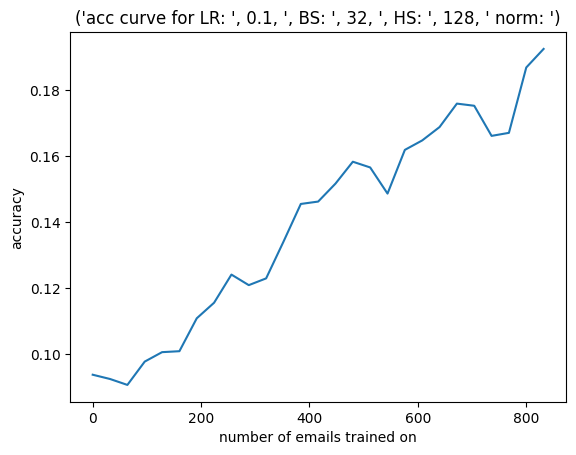

 70%|███████   | 700/1000 [45:54<16:30,  3.30s/it]

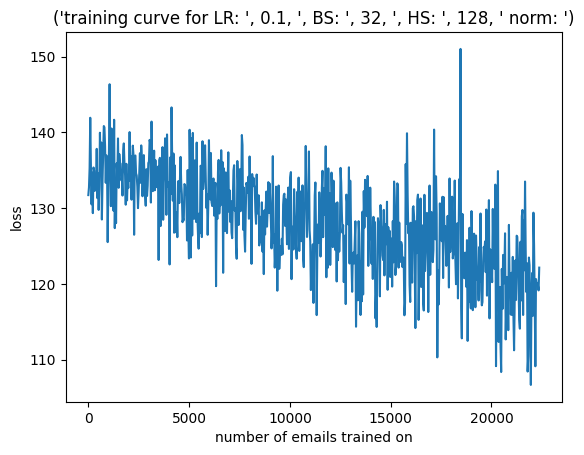

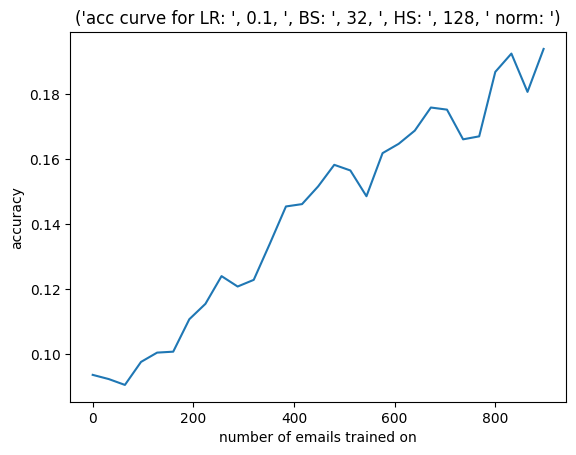

 75%|███████▌  | 750/1000 [49:05<13:59,  3.36s/it]

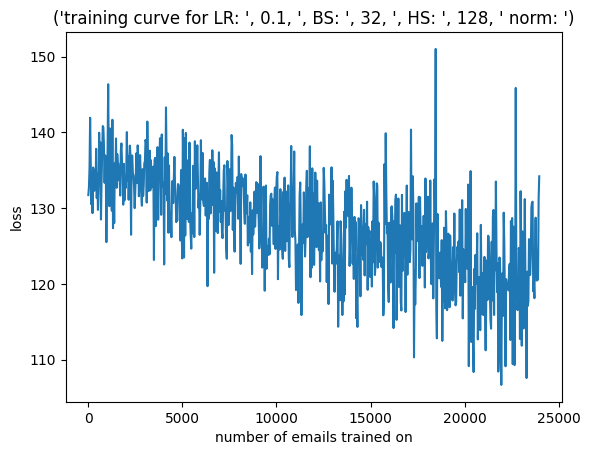

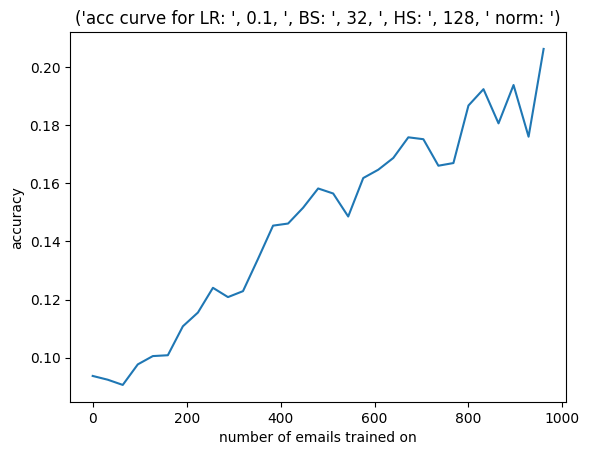

 80%|████████  | 800/1000 [52:15<11:14,  3.37s/it]

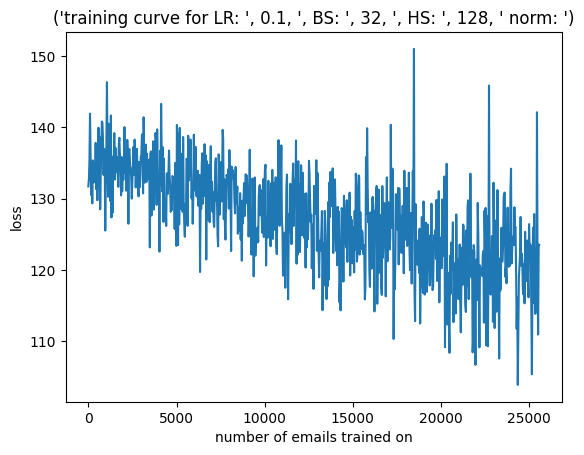

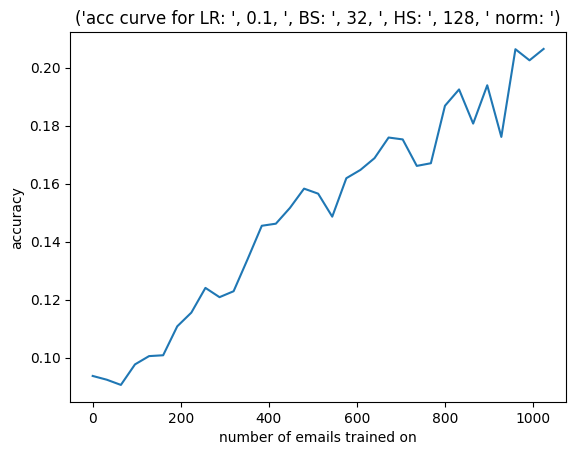

 85%|████████▌ | 850/1000 [55:26<08:05,  3.24s/it]

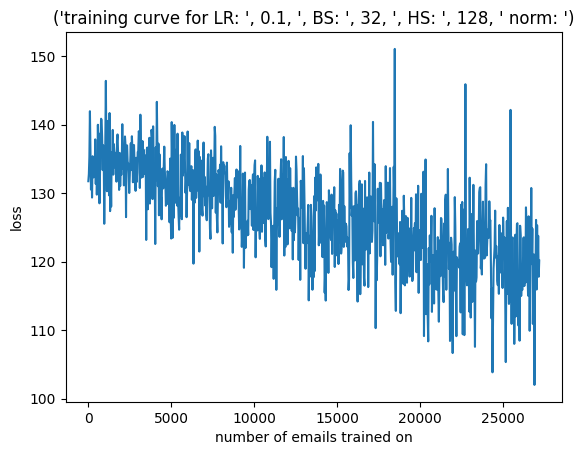

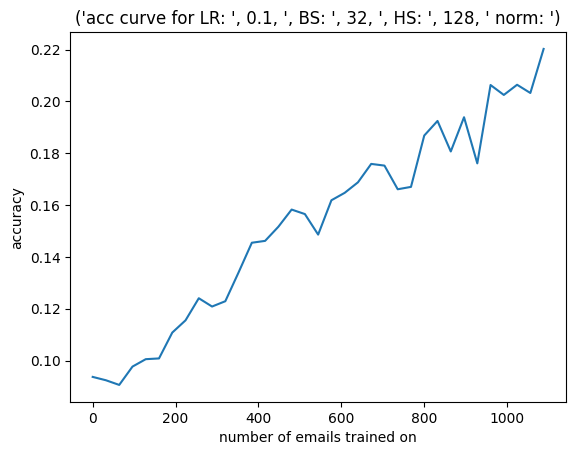

 90%|█████████ | 900/1000 [58:35<05:25,  3.25s/it]

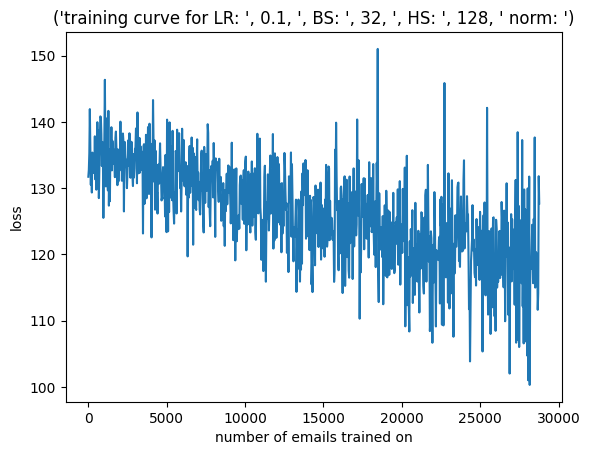

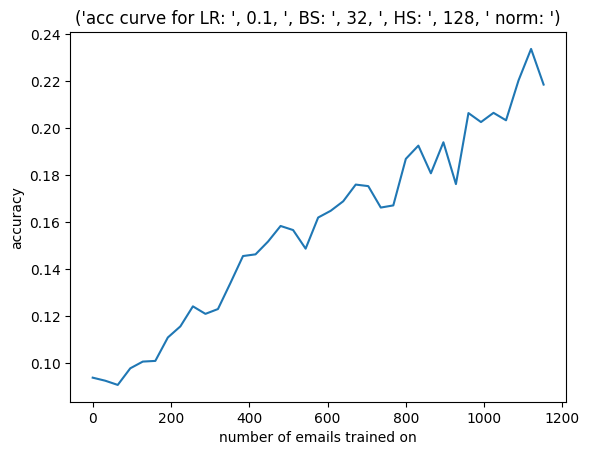

 95%|█████████▌| 950/1000 [1:01:43<02:44,  3.28s/it]

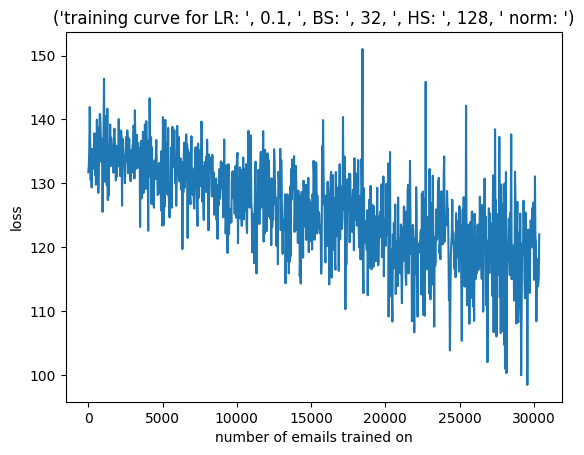

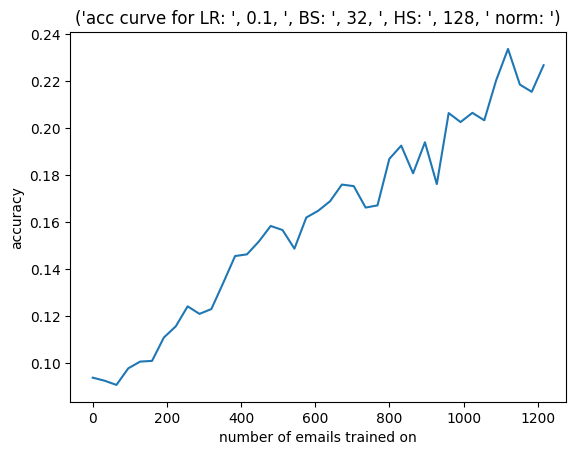

100%|██████████| 1000/1000 [1:04:49<00:00,  3.89s/it]


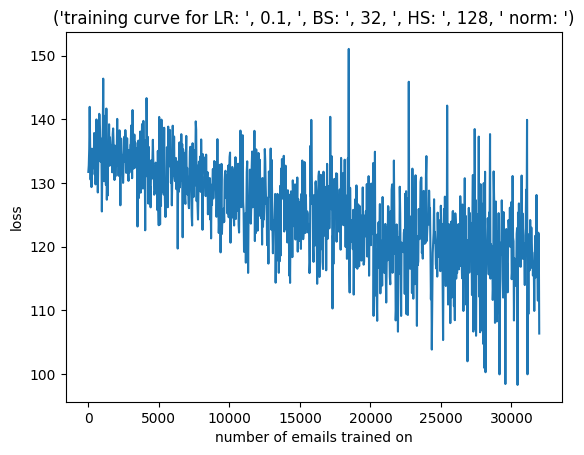

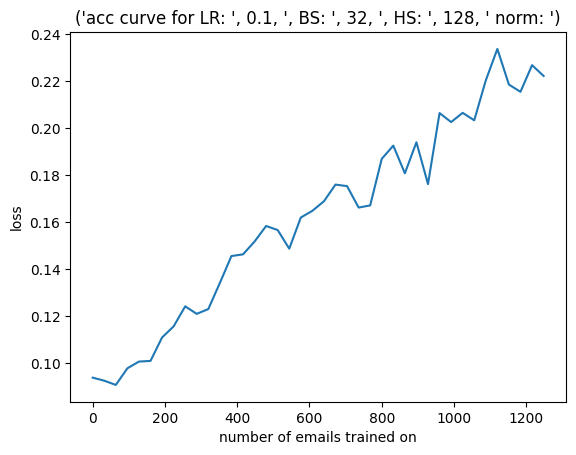

In [424]:


new_cell = more_train(cell, dataset, input_size, 128, 32, 0.1, sequence_len,1)

  0%|          | 0/100 [00:00<?, ?it/s]

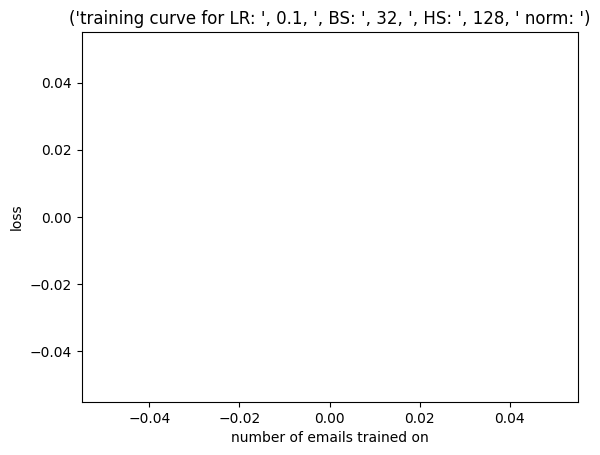

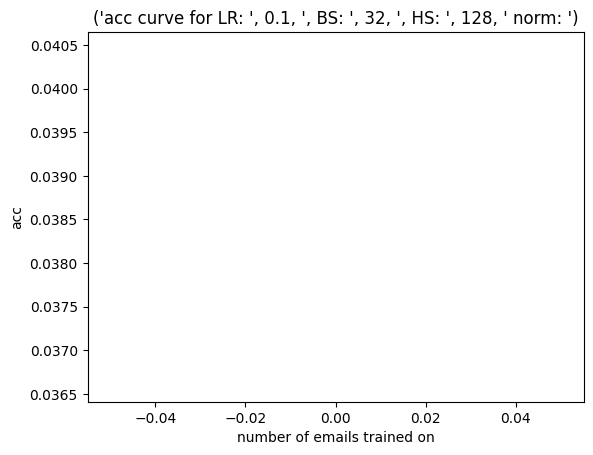

100%|██████████| 100/100 [06:17<00:00,  3.77s/it]


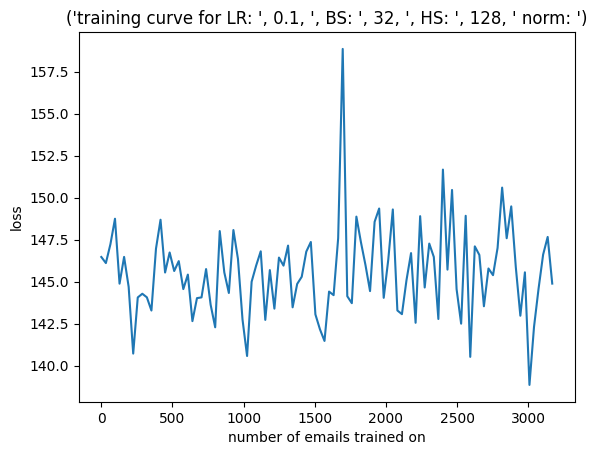

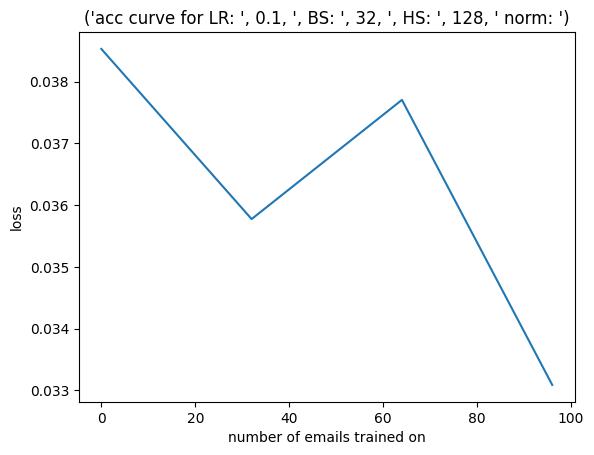

In [353]:
new_to_train = copy.deepcopy(new_cell)

final_cell = more_train(new_to_train, dataset, input_size, 128, 32, 0.1, sequence_len,1)

In [349]:
from numpy import int64, int8


def get_output(cell, seed, length, input_size, batch_size, seq_len):

    text_out = seed
    
    

    seed = sp.encode_as_ids(seed)
    print(len(seed))
    hot = np.array(one_hot(input_size,seed))
    print(hot.shape)

    prevA = np.zeros((1,hidden_size))
    prevC = np.zeros((1,hidden_size))

    # for i in range(len(hot)):
    #     print(np.atleashot[i].shape)

    # print(seed)

    dist = np.arange(0, input_size)
    # print(dist)

    for i in range(1, seq_len-1):

        inp = np.atleast_2d(hot[i])

        forward = forward_pass(cell, prevA, prevC, inp)

        prevA = forward["A_t"]
        prevC = forward["C_t"]
    
    inp = np.atleast_2d(hot[seq_len-1:seq_len])

    
    out = []
    for i in range(0, length):
        
        
        forward = forward_pass(cell, prevA, prevC, inp)

        inter_out = np.array(np.random.choice(dist, p=forward["Yhat"]))

        
        out.append(int(inter_out))

        inp = np.zeros(input_size)
        inp[out] = 1
        inp = np.atleast_2d(inp)

        prevA = forward["A_t"]
        prevC = forward["C_t"]

    

    text_out += sp.decode(out)
    print(out)

    return text_out


In [468]:

print(get_output(new_cell, "i am an african prince in need of ", 300, 2500, 1, 9))


9
(9, 2500)
[4, 94, 605, 94, 106, 61, 193, 94, 1474, 7, 1993, 29, 23, 405, 9, 1873, 15, 99, 577, 416, 877, 1144, 247, 1040, 22, 321, 994, 321, 435, 470, 118, 70, 45, 517, 95, 70, 966, 763, 50, 339, 405, 475, 321, 1344, 1251, 16, 6, 142, 321, 954, 101, 118, 134, 450, 154, 118, 374, 15, 176, 159, 118, 173, 118, 191, 12, 1319, 467, 985, 70, 321, 1222, 297, 101, 134, 326, 1179, 118, 38, 1464, 306, 56, 38, 134, 1052, 981, 450, 70, 142, 255, 230, 145, 1303, 338, 457, 1491, 134, 29, 605, 95, 134, 1195, 189, 801, 321, 578, 1144, 134, 183, 70, 657, 371, 1948, 371, 118, 1115, 118, 1898, 1778, 452, 134, 1312, 405, 17, 1709, 45, 636, 59, 155, 243, 227, 45, 230, 77, 96, 45, 232, 134, 12, 77, 2154, 341, 450, 864, 134, 134, 134, 134, 542, 450, 532, 134, 118, 954, 292, 337, 657, 70, 134, 101, 134, 118, 134, 662, 142, 134, 475, 142, 118, 101, 321, 118, 1079, 1097, 338, 394, 142, 566, 130, 134, 134, 343, 38, 130, 233, 616, 16, 101, 337, 16, 811, 159, 316, 101, 118, 134, 134, 142, 134, 903, 1844, 38, 4, 